In [1]:
# Task 1 - First, we simulate the cash flows
import numpy as np
import pandas as pd
from scipy.special import erf
import matplotlib.pyplot as plt


# Just adding a touch of proper formatting
pd.options.display.float_format = '{:,.2f}'.format

# Set parameters that we have information on
N_BONDS = 10
FACE = 10_000_000                  # $10MM per bond
COUPON_ANNUAL = 0.06               # 6% annual coupon on assets
COUPON_Q = COUPON_ANNUAL / 4.0     # per quarter
LGD = 0.60
RECOVERY = (1 - LGD) * FACE        
ANNUAL_PD = 0.04
RHO = 0.20
T_YEARS = 5
N_Q = T_YEARS * 4
DT = 0.25
LAMBDA = -np.log(1 - ANNUAL_PD)
RF = 0.01                          # Risk-free rate for discounting (continuous)

# Used in later tasks, just setting up the tranches
B_NOTIONAL = 10_000_000
B_COUPON_ANNUAL = 0.04
B_COUPON_Q = B_COUPON_ANNUAL / 4.0

# Functions that will help us perform our simulations
def phi_cdf(z):
    # Returns cdf value array from standard normal distribution
    return 0.5 * (1.0 + erf(z / np.sqrt(2.0)))

def simulate_default_times_gaussian_copula(n_paths, seed):
    # Returns the default times for correlated bonds
    rng = np.random.default_rng(seed)
    # Creating the correlation matrix
    C = RHO * np.ones((N_BONDS, N_BONDS)) + (1 - RHO) * np.eye(N_BONDS)
    L = np.linalg.cholesky(C)
    
    # Now we generate correlated standard normal variables
    Z = rng.standard_normal(size=(n_paths, N_BONDS)) @ L.T
    
    # Converting them to uniform vals and then to geometric default times (we adjust them in simulate_portfolio_cashflows)
    U = np.clip(phi_cdf(Z), 1e-12, 1 - 1e-12)
    return -np.log(1 - U) / LAMBDA

def simulate_portfolio_cashflows(n_paths, seed):
    # Where we actually simulate the cash flows
    Tdef = simulate_default_times_gaussian_copula(n_paths, seed)
    
    # Determining which quarter each bond defaults in
    default_q = np.zeros_like(Tdef, dtype=int)
    for q in range(1, N_Q + 1):
        q_start, q_end = (q - 1) * DT, q * DT
        default_q[(Tdef > q_start) & (Tdef <= q_end)] = q
    
    survive = (Tdef > T_YEARS)

    agg_cf = np.zeros((n_paths, N_Q), float)
    coupon_per_bond_q = FACE * COUPON_Q
    
    for q in range(1, N_Q + 1):
        # Checking which bonds are alive at the start of the quarter
        alive = (default_q == 0) | (default_q > q)
        coupons = alive.sum(axis=1) * coupon_per_bond_q
        
        # Finding the number of recoveries from bonds defaulting this quarter
        recovs = (default_q == q).sum(axis=1) * RECOVERY
        
        # Checking which principal from bonds survived to the end
        principal = survive.sum(axis=1) * FACE if q == N_Q else 0.0
        
        agg_cf[:, q - 1] = coupons + recovs + principal
        
    return agg_cf

# Creating some standard output for our first task
print("Task 1: Simulating Aggregate Portfolio Cash Flows")
N_PATHS_SIM = 10000
agg_cf = simulate_portfolio_cashflows(n_paths=N_PATHS_SIM, seed=11)

print(f"\nSimulation run with {N_PATHS_SIM:,} paths.")
print(f"Resulting aggregate cash flow matrix shape: {agg_cf.shape}")

# Creating a df which stores the sample cash flow simulations
df_agg_cf_sample = pd.DataFrame(agg_cf)
df_agg_cf_sample.columns = [f"Q{i+1}" for i in range(N_Q)]
df_agg_cf_sample.index.name = "Path"

print("\nSample of Aggregate Cash Flows (first 5 paths, first 6 quarters):")
display(df_agg_cf_sample.head(5).iloc[:, :6])

# Calculating expected cash flow per quarter
expected_quarterly_cf = agg_cf.mean(axis=0)
print(f"\nAverage cash flow in Q1: ${expected_quarterly_cf[0]:,.0f}")
print(f"Average cash flow in Q20 (including principal): ${expected_quarterly_cf[-1]:,.0f}")

Task 1: Simulating Aggregate Portfolio Cash Flows

Simulation run with 10,000 paths.
Resulting aggregate cash flow matrix shape: (10000, 20)

Sample of Aggregate Cash Flows (first 5 paths, first 6 quarters):


,Q1,Q2,Q3,Q4,Q5,Q6
Path,,,,,,
0,"1,500,000.00","1,500,000.00","1,500,000.00","1,500,000.00","1,500,000.00","1,500,000.00"
1,"1,500,000.00","1,500,000.00","1,500,000.00","1,500,000.00","1,500,000.00","1,500,000.00"
2,"1,500,000.00","9,200,000.00","5,050,000.00","1,050,000.00","4,900,000.00","900,000.00"
3,"1,500,000.00","1,500,000.00","1,500,000.00","1,500,000.00","1,500,000.00","1,500,000.00"
4,"1,500,000.00","1,500,000.00","1,500,000.00","1,500,000.00","5,350,000.00","1,350,000.00"



Average cash flow in Q1: $1,889,235
Average cash flow in Q20 (including principal): $82,989,630


In [2]:
# Task 2 - Applying Waterfall Rules to the tranche layers

def apply_waterfall(agg_cf, A_notional, B_notional):
    # Goal of this function is to successfully use the waterfall rule to understand payment structure of each tranche
    n_paths = agg_cf.shape[0]
    A_coupon_q = A_notional * (0.02 / 4.0)
    B_coupon_q = B_notional * (0.04 / 4.0)

    A_cf = np.zeros_like(agg_cf)
    B_cf = np.zeros_like(agg_cf)
    
    for i in range(n_paths):
        # Checking each simulation at a time
        for q in range(N_Q):
            avail = agg_cf[i, q]

            # Paying Tranche A coupon
            pay_A_coupon = min(avail, A_coupon_q)
            A_cf[i, q] += pay_A_coupon
            avail -= pay_A_coupon

            # Paying Tranche B coupon
            pay_B_coupon = min(avail, B_coupon_q)
            B_cf[i, q] += pay_B_coupon
            avail -= pay_B_coupon

            # At maturity, repaying principal
            if q == N_Q - 1:
                # Paying Class A principal
                pay_A_prin = min(avail, A_notional)
                A_cf[i, q] += pay_A_prin
                avail -= pay_A_prin
                
                # Paying Class B principal
                pay_B_prin = min(avail, B_notional)
                B_cf[i, q] += pay_B_prin
                avail -= pay_B_prin
    
    return A_cf, B_cf

# Standard output for Task 2
print("--- Task 2: Applying Waterfall to Initial Structure ---")
# Setting up tranche constants
A_NOTIONAL_INITIAL = 20_000_000
B_NOTIONAL_INITIAL = 10_000_000

A_cf_realized, B_cf_realized = apply_waterfall(agg_cf, A_NOTIONAL_INITIAL, B_NOTIONAL_INITIAL)

# Analyzing the results for this structure
A_promised_coupon = A_NOTIONAL_INITIAL * (0.02 / 4)
B_promised_coupon = B_NOTIONAL_INITIAL * (0.04 / 4)

A_avg_received_coupon = A_cf_realized[:, :-1].mean()
B_avg_received_coupon = B_cf_realized[:, :-1].mean()

A_total_promised = (A_promised_coupon * N_Q) + A_NOTIONAL_INITIAL
B_total_promised = (B_promised_coupon * N_Q) + B_NOTIONAL_INITIAL

A_avg_total_received = A_cf_realized.sum(axis=1).mean()
B_avg_total_received = B_cf_realized.sum(axis=1).mean()

A_expected_shortfall = A_total_promised - A_avg_total_received
B_expected_shortfall = B_total_promised - B_avg_total_received

print(f"\nAnalysis for initial structure (A=${A_NOTIONAL_INITIAL/1e6:.0f}M, B=${B_NOTIONAL_INITIAL/1e6:.0f}M):")
print("\n--- Tranche A ---")
print(f"Promised Quarterly Coupon: ${A_promised_coupon:,.0f}")
print(f"Average Realized Quarterly Coupon (Q1-19): ${A_avg_received_coupon:,.0f}")
print(f"Total Promised (Coupons + Principal): ${A_total_promised:,.0f}")
print(f"Average Total Realized: ${A_avg_total_received:,.0f}")
print(f"Expected Total Shortfall over 5 years: ${A_expected_shortfall:,.0f}")

print("\n--- Tranche B ---")
print(f"Promised Quarterly Coupon: ${B_promised_coupon:,.0f}")
print(f"Average Realized Quarterly Coupon (Q1-19): ${B_avg_received_coupon:,.0f}")
print(f"Total Promised (Coupons + Principal): ${B_total_promised:,.0f}")
print(f"Average Total Realized: ${B_avg_total_received:,.0f}")
print(f"Expected Total Shortfall over 5 years: ${B_expected_shortfall:,.0f}")

--- Task 2: Applying Waterfall to Initial Structure ---

Analysis for initial structure (A=$20M, B=$10M):

--- Tranche A ---
Promised Quarterly Coupon: $100,000
Average Realized Quarterly Coupon (Q1-19): $100,000
Total Promised (Coupons + Principal): $22,000,000
Average Total Realized: $21,988,135
Expected Total Shortfall over 5 years: $11,865

--- Tranche B ---
Promised Quarterly Coupon: $100,000
Average Realized Quarterly Coupon (Q1-19): $99,991
Total Promised (Coupons + Principal): $12,000,000
Average Total Realized: $11,950,620
Expected Total Shortfall over 5 years: $49,380


In [3]:
# Task 3 - Maximum Tranche A sizing for Aa rating

# Moody's Aa 5-year target (pulled this value from page 2 of https://ratings.moodys.com/api/rmc-documents/427804)
EL_TARGET = 0.0033

# Creating discount factors for PV calculations for vectorized multiplication
quarters = np.arange(1, N_Q + 1)
t_years = quarters * DT
disc_factors = np.exp(-RF * t_years)

def promised_A_cashflows(A_notional):
    # Calculating the cash flows promised to Tranche A
    A_coupon_q = A_notional * (0.02 / 4.0)
    stream = np.full(N_Q, A_coupon_q, float)
    stream[-1] += A_notional  # Principal due at maturity
    return stream

def expected_loss_A_percent(agg_cf, A_notional):
    # Finding the expected loss of cashflows in Tranche A
    
    # We only need Tranche A's cash flows for its own EL calculation
    A_cf_realized, _ = apply_waterfall(agg_cf, A_notional, B_NOTIONAL)
    
    promised = promised_A_cashflows(A_notional)
    
    # Calculating shortfall for each path and each quarter
    shortfalls = np.maximum(promised - A_cf_realized, 0.0)
    
    # Discounting to PV
    pv_shortfalls = shortfalls * disc_factors
    
    # Calculating the average PV shortfall across all paths
    expected_pv_shortfall = pv_shortfalls.mean(axis=0).sum()
    
    return expected_pv_shortfall / A_notional

def size_A_for_target_EL(agg_cf, el_target, a_min=1e6, a_max=80e6, tol=1e3):
    lo, hi = a_min, a_max
    for _ in range(60):
        mid = 0.5*(lo+hi)
        el_mid = expected_loss_A_percent(agg_cf, mid)
        if el_mid <= el_target: lo = mid
        else: hi = mid
        if (hi - lo) < tol: break
    A_star = lo
    EL_star = expected_loss_A_percent(agg_cf, A_star)
    return A_star, EL_star


# Task 3 Standard output
print("--- Task 3: Sizing Tranche A to meet Moody's Aa Rating Target ---")
A_star, EL_star = size_A_for_target_EL(agg_cf, el_target=EL_TARGET)

print(f"\nTarget EL for Moody's Aa (5-year): {EL_TARGET * 100:.3f}%")
print(f"Maximum Tranche A Notional meeting target: ${A_star:,.0f}")
print(f"Resulting Expected Loss at this size: {EL_star * 100:.3f}%")

# --- Optional Sensitivity Analysis ---
print("\n--- Sensitivity of Expected Loss to Tranche A Notional ---")
grid_start = max(1_000_000, A_star - 10_000_000)
grid_end = min(80_000_000, A_star + 5_000_000)
grid = np.linspace(grid_start, grid_end, 7)
rows = []
for a_notional in grid:
    el = expected_loss_A_percent(agg_cf, a_notional)
    rows.append((a_notional, el * 100))

df_sensitivity = pd.DataFrame(rows, columns=["A_Notional_$", "EL_A_%"])
df_sensitivity.loc[len(df_sensitivity.index)] = [A_star, EL_star * 100]
df_sensitivity = df_sensitivity.sort_values(by="A_Notional_$").reset_index(drop=True)
display(df_sensitivity)

--- Task 3: Sizing Tranche A to meet Moody's Aa Rating Target ---

Target EL for Moody's Aa (5-year): 0.330%
Maximum Tranche A Notional meeting target: $34,346,207
Resulting Expected Loss at this size: 0.330%

--- Sensitivity of Expected Loss to Tranche A Notional ---


,A_Notional_$,EL_A_%
0,"24,346,206.67",0.13
1,"26,846,206.67",0.16
2,"29,346,206.67",0.19
3,"31,846,206.67",0.25
4,"34,346,206.67",0.33
5,"34,346,206.67",0.33
6,"36,846,206.67",0.41
7,"39,346,206.67",0.48


In [4]:
# Task 4 - Valuation, Risk Metrics, and ROE

print("Task 4: Valuation and Risk Analysis")

# Calculating PD and LGD for Class B (Undiscounted)
print("\nRisk Analysis for Tranche B")

A_cf_realized, B_cf_realized = apply_waterfall(agg_cf, A_star, B_NOTIONAL)

B_promised_coupon_q = B_NOTIONAL * B_COUPON_Q
B_total_promised = (B_promised_coupon_q * N_Q) + B_NOTIONAL
B_total_realized_paths = B_cf_realized.sum(axis=1)

shortfall_paths = B_total_realized_paths < B_total_promised
num_default_paths = shortfall_paths.sum()
B_pd = num_default_paths / N_PATHS_SIM

shortfall_amounts = np.maximum(0, B_total_promised - B_total_realized_paths)
default_path_shortfalls = shortfall_amounts[shortfall_paths]

B_elgd_dollars = default_path_shortfalls.mean() if num_default_paths > 0 else 0
B_lgd_percent = (B_elgd_dollars / B_total_promised) if B_total_promised > 0 else 0

print(f"Total Amount Promised to Tranche B: ${B_total_promised:,.0f}")
print(f"Number of Simulation Paths with a Shortfall: {num_default_paths:,} out of {N_PATHS_SIM:,}")
print(f"Probability of Default (PD) for Tranche B: {B_pd:.2%}")
print(f"Expected Loss (in $) GIVEN a default occurs: ${B_elgd_dollars:,.0f}")
print(f"Loss Given Default (LGD) for Tranche B: {B_lgd_percent:.2%}")


# Valuing of Tranche A, B, and Equity
print("\n--- Part 2: Valuation of Tranches ---")

# Defining discount rates from the problem
DISCOUNT_RATE_A = RF + 0.0050  # RF + 50 bps
DISCOUNT_RATE_B = RF + 0.0400  # RF + 400 bps
DISCOUNT_RATE_PORTFOLIO = 0.09 # Market YTM of the underlying bonds

print(f"Discount Rates Used:")
print(f"  - Portfolio Assets: {DISCOUNT_RATE_PORTFOLIO:.2%} (Market YTM)")
print(f"  - Tranche A Liability: {DISCOUNT_RATE_A:.2%}")
print(f"  - Tranche B Liability: {DISCOUNT_RATE_B:.2%}")

# The market value of the asset portfolio is the PV of its *promised* cash flows,
# discounted at the market YTM.
TOTAL_NOTIONAL = N_BONDS * FACE
promised_portfolio_coupon_q = TOTAL_NOTIONAL * COUPON_Q
promised_portfolio_cf = np.full(N_Q, promised_portfolio_coupon_q)
promised_portfolio_cf[-1] += TOTAL_NOTIONAL

t_years = (np.arange(1, N_Q + 1)) * DT
disc_factors_portfolio = np.exp(-DISCOUNT_RATE_PORTFOLIO * t_years)
Value_Portfolio = (promised_portfolio_cf * disc_factors_portfolio).sum()

# The value of the tranches is the PV of their *expected* (simulated) cash flows,
# discounted at their respective required rates of return.
A_expected_cf = A_cf_realized.mean(axis=0)
B_expected_cf = B_cf_realized.mean(axis=0)

disc_factors_A = np.exp(-DISCOUNT_RATE_A * t_years)
disc_factors_B = np.exp(-DISCOUNT_RATE_B * t_years)

Value_A = (A_expected_cf * disc_factors_A).sum()
Value_B = (B_expected_cf * disc_factors_B).sum()

# Based on the principle: Value(Assets) = Value(Liabilities) + Value(Equity)
Value_Equity = Value_Portfolio - Value_A - Value_B

print("\nMarket Values:")
print(f"Value of Total Asset Portfolio: ${Value_Portfolio:,.0f}")
print(f"--------------------------------------------------")
print(f"Value of Tranche A: ${Value_A:,.0f}")
print(f"Value of Tranche B: ${Value_B:,.0f}")
print(f"Value of Equity (as residual):  ${Value_Equity:,.0f}")
print(f"--------------------------------------------------")
Total_Liabilities_Value = Value_A + Value_B + Value_Equity
print(f"Check: Total Value of Liabilities + Equity: ${Total_Liabilities_Value:,.0f}")


# --- ROE for the bank (as equity holder) ---
print("\nReturn on Equity")

# The bank's "investment" is the market value of the equity piece it retains.
Bank_Investment = Value_Equity

# The bank's "return" is the total *expected* undiscounted cash flow it receives.
Equity_cf_realized = agg_cf - A_cf_realized - B_cf_realized
Total_Expected_Equity_CF = Equity_cf_realized.mean(axis=0).sum()

# Total Return over the 5-year period (Holding Period Return)
total_return_5y = (Total_Expected_Equity_CF - Bank_Investment) / Bank_Investment

# Annualized Return (Geometric Average / CAGR)
annualized_roe = (1 + total_return_5y)**(1 / T_YEARS) - 1

print(f"Bank's Initial Investment (Market Value of Equity): ${Bank_Investment:,.0f}")
print(f"Total Expected Undiscounted Cash Flow to Equity: ${Total_Expected_Equity_CF:,.0f}")
print(f"Total Return on Equity over 5 years: {total_return_5y:.2%}")
print(f"Annualized Return on Equity (ROE): {annualized_roe:.2%}")

Task 4: Valuation and Risk Analysis

Risk Analysis for Tranche B
Total Amount Promised to Tranche B: $12,000,000
Number of Simulation Paths with a Shortfall: 385 out of 10,000
Probability of Default (PD) for Tranche B: 3.85%
Expected Loss (in $) GIVEN a default occurs: $6,155,112
Loss Given Default (LGD) for Tranche B: 51.29%

--- Part 2: Valuation of Tranches ---
Discount Rates Used:
  - Portfolio Assets: 9.00% (Market YTM)
  - Tranche A Liability: 1.50%
  - Tranche B Liability: 5.00%

Market Values:
Value of Total Asset Portfolio: $87,650,179
--------------------------------------------------
Value of Tranche A: $35,056,708
Value of Tranche B: $9,361,999
Value of Equity (as residual):  $43,231,472
--------------------------------------------------
Check: Total Value of Liabilities + Equity: $87,650,179

Return on Equity
Bank's Initial Investment (Market Value of Equity): $43,231,472
Total Expected Undiscounted Cash Flow to Equity: $66,406,987
Total Return on Equity over 5 years: 53.6

Part 2: Task 5 - Why a Bank Creates This Structure

This is the business-side of the assignment. A bank undertakes the complex and expensive process of creating a CDO for several powerful strategic reasons.

1. Arbitrage and Profit Generation

    This is the most direct motivation. The bank is creating a profitable "spread" business.
    
    The Assets: The bank holds a portfolio of bonds yielding a relatively high rate (in this case, the YTM is 9% and the coupon is 6%).
    
    The Liabilities: The bank issues new securities (the CDO tranches) that pay a much lower interest rate (2% for Class A, 4% for Class B).
    
    The Profit: The bank, as the equity holder, pockets the difference between the cash flow coming in from the assets and the cash flow going out to the tranche investors. This residual spread can be highly lucrative if defaults are low.

2. Regulatory Capital Relief

    This is arguably the most important and powerful driver for securitization.
    
    The Problem: Banks are required by regulators (like the FED) to hold a certain amount of their own capital in reserve against the risky assets on their balance sheet. Speculative-grade corporate bonds require a significant amount of this reserve capital, which is essentially "dead money" that the bank cannot use to make new loans.
    
    The Solution: By packaging these bonds into a CDO and selling the tranches to outside investors, the bank effectively removes the assets from its balance sheet. In our example, by selling a ~37M Class A and a 10M Class B tranche, the bank has transferred the risk of $47 million of assets to others. This frees up the regulatory capital that was tied up supporting those assets, allowing the bank to use it for more profitable activities, like new lending.

3. Balance Sheet Management and Risk Transfer

    Moving Risk: The primary function of a CDO is to slice up and redistribute risk. The bank may have an over-concentration of risk in a particular industry or credit quality. By creating and selling the CDO tranches, it transfers the bulk of the risk (especially the "first-loss" and "mezzanine" risk if they sell those tranches too) to other investors who have a different risk appetite (like hedge funds or insurance companies).
    
    Liquidity Creation: A portfolio of 10 individual speculative bonds might be difficult to sell quickly (i.e., they are illiquid). However, a highly-rated, $37M Class A tranche with a Moody's Aa rating is a standardized product that can be sold very easily into a deep and liquid market of conservative investors. The bank turns illiquid assets into cash.

4. Meeting Investor Demand

    The bank is also acting as a market-maker, creating products that different clients want.
    
    Conservative Investors (Pension Funds, Insurers): There is enormous global demand for safe, yield-producing assets. These investors cannot or will not buy the speculative bonds directly, but they are eager to buy the Aa-rated Class A tranche, which offers a higher yield than a government bond (1.5% vs 1%) with very similar perceived safety.
    
    Risk-Seeking Investors (Hedge Funds, Specialized Funds): Other investors are constantly searching for higher returns and are willing to take on more risk. The Class B tranche, and potentially even a slice of the equity, is an attractive investment for them.
    
    By creating all these different risk-return profiles from a single pool of assets, the bank serves a wide range of client needs, earning fees in the process.




## Below is what we transformed it into

In this particular CDO structure, the bank’s motivation is clear when you look at the economics of the deal. The underlying assets consist of ten speculative-grade corporate bonds yielding 9% in the market, while the bank issues two tranches that pay investors much lower coupons, just 2% on the 20 million Class A and 4% on the 10 million Class B. The difference between the high yield earned on the collateral and the much lower cost of the CDO liabilities creates an attractive spread. The bank, which keeps the residual (equity) piece, captures this spread as profit, as long as defaults remain manageable. Beyond the pure arbitrage, the CDO helps the bank achieve regulatory capital relief. By selling the Class A and B tranches (about $30 million of risk transferred), the bank moves those exposures off its balance sheet, freeing up capital that would otherwise be locked against speculative-grade assets. This allows it to redeploy that capital into new loans or investments, effectively expanding lending capacity without taking on additional regulatory burden. The structure also transforms the risk profile of the portfolio: rather than holding a concentrated position in ten BB-rated bonds with correlated default risk, the bank now holds a smaller, first-loss equity piece and passes senior risk to external investors. Finally, the deal satisfies market demand from both ends, pension funds and insurers gain access to a high-quality Aa-rated tranche offering 2%, while hedge funds can buy the riskier B tranche for higher returns. In short, this CDO lets the bank earn a leveraged spread, offload risk, free capital, and meet investor appetite, turning a portfolio of risky bonds into a flexible and profitable financing instrument.

In [5]:
# Task 5: Mezzanine / Risk-Charge Extension (market-consistent valuation with shared k)
quarters = np.arange(1, N_Q + 1)
t_years = quarters * DT
disc_rf = np.exp(-RF * t_years)

def tranche_cashflows_paths(agg_cf, A_notional, B_notional):
    # Using waterfall rule
    A_cf, B_cf = apply_waterfall(agg_cf, A_notional, B_notional)
    R_cf = agg_cf - A_cf - B_cf
    return A_cf, B_cf, R_cf

def pv_paths(cf_paths, disc):
    # Getting the PV of each path
    return (cf_paths * disc).sum(axis=1)

def market_value_of_collateral_at_ytm(num_bonds, face, coupon_annual, ytm_annual):
    total_face = num_bonds * face
    coupon_q = total_face * (coupon_annual / 4.0)
    promised = np.full(N_Q, coupon_q, dtype=float)
    promised[-1] += total_face
    disc_mkt = np.exp(-ytm_annual * t_years)
    return float((promised * disc_mkt).sum())

def covariance_and_moments(A_pv_paths, B_pv_paths, R_pv_paths):
    # Creating the covariance matrix
    X = np.column_stack([A_pv_paths, B_pv_paths, R_pv_paths])
    C = np.cov(X, rowvar=False, ddof=1)
    ones = np.array([1.0, 1.0, 1.0])
    var_T = ones @ C @ ones
    covA_T = np.array([1.0, 0.0, 0.0]) @ C @ ones
    covB_T = np.array([0.0, 1.0, 0.0]) @ C @ ones
    covR_T = np.array([0.0, 0.0, 1.0]) @ C @ ones
    return C, var_T, covA_T, covB_T, covR_T

def solve_k(E_T, P_market_T, Var_T):
    # Getting k
    if Var_T <= 0:
        raise ValueError("Var(T) must be positive to solve for k.")
    return (E_T - P_market_T) / Var_T

def value_classes(E_A, E_B, E_R, covA_T, covB_T, covR_T, k):
    val_A = E_A - k * covA_T
    val_B = E_B - k * covB_T
    val_R = E_R - k * covR_T
    return val_A, val_B, val_R

def shortfall_frequencies(A_cf, B_cf, A_notional, B_notional):
    # Just finding how often the tranches are paid short of full
    A_coupon_due = A_notional * (0.02 / 4.0)
    B_coupon_due = B_notional * (0.04 / 4.0)
    A_cpn_paid = np.minimum(A_cf, A_coupon_due)
    B_cpn_paid = np.minimum(B_cf, B_coupon_due)
    A_short = (A_cpn_paid < A_coupon_due).mean()
    B_short = (B_cpn_paid < B_coupon_due).mean()
    return A_short, B_short

def run_risk_charge_pricing(agg_cf, A_notional, B_notional, ytm_assets):
    # Running all of the functions we created above to get our covariance matrix and get optimal k

    A_cf, B_cf, R_cf = tranche_cashflows_paths(agg_cf, A_notional, B_notional)
    A_pv = pv_paths(A_cf, disc_rf)
    B_pv = pv_paths(B_cf, disc_rf)
    R_pv = pv_paths(R_cf, disc_rf)

    C, var_T, covA_T, covB_T, covR_T = covariance_and_moments(A_pv, B_pv, R_pv)

    E_A, E_B, E_R = A_pv.mean(), B_pv.mean(), R_pv.mean()
    E_T = E_A + E_B + E_R  # identity check

    P_mkt_T = market_value_of_collateral_at_ytm(
        num_bonds=N_BONDS, face=FACE, coupon_annual=COUPON_ANNUAL, ytm_annual=ytm_assets
    )

    k = solve_k(E_T, P_mkt_T, var_T)
    val_A, val_B, val_R = value_classes(E_A, E_B, E_R, covA_T, covB_T, covR_T, k)

    A_short, B_short = shortfall_frequencies(A_cf, B_cf, A_notional, B_notional)
    identities_ok = np.isclose(val_A + val_B + val_R, P_mkt_T, rtol=0, atol=1e-6)

    results = {
        "k": k,
        "E_A_rfPV": E_A, "E_B_rfPV": E_B, "E_R_rfPV": E_R, "E_T_rfPV": E_T,
        "Var_T": var_T, "CovA_T": covA_T, "CovB_T": covB_T, "CovR_T": covR_T,
        "Value_A": val_A, "Value_B": val_B, "Value_R": val_R,
        "P_market_T": P_mkt_T,
        "Identity_ValueSum_Equals_Pmkt": identities_ok,
        "A_coupon_shortfall_freq": A_short,
        "B_coupon_shortfall_freq": B_short,
        "CovMatrix_ABR": C,
    }
    return results

# Choose which A/B levels to evaluate here.
A_for_mezz = float(A_star) if 'A_star' in globals() else 20_000_000.0
B_for_mezz = float(B_NOTIONAL)

print("\n--- Risk-Charge Valuation (shared k) ---")
mezz = run_risk_charge_pricing(agg_cf, A_for_mezz, B_for_mezz, ytm_assets=0.09)

# Pretty print
def _fmt(x): return f"${x:,.0f}" if isinstance(x, (int, float)) else x

print(f"k (shared cost of risk): {mezz['k']:.12f}")
print(f"Risk-free PVs (E[PV_rf]): A={_fmt(mezz['E_A_rfPV'])}, B={_fmt(mezz['E_B_rfPV'])}, R={_fmt(mezz['E_R_rfPV'])}, Total={_fmt(mezz['E_T_rfPV'])}")
print(f"Var(T): {mezz['Var_T']:.3e} | Cov(A,T): {mezz['CovA_T']:.3e} | Cov(B,T): {mezz['CovB_T']:.3e} | Cov(R,T): {mezz['CovR_T']:.3e}")
print(f"Market value of collateral at 9% YTM: {_fmt(mezz['P_market_T'])}")
print(f"Implied Values: A={_fmt(mezz['Value_A'])}, B={_fmt(mezz['Value_B'])}, Residual={_fmt(mezz['Value_R'])}")
print(f"Identity check (A+B+R == P_mkt): {mezz['Identity_ValueSum_Equals_Pmkt']}")
print(f"Coupon shortfall frequency: A={mezz['A_coupon_shortfall_freq']:.3%}, B={mezz['B_coupon_shortfall_freq']:.3%}")

# ------- OPTIONAL: Sensitivity helpers (call only if you want plots/tables) -------
def sensitivity_over_grid(agg_cf: np.ndarray,
                          A_grid, B_grid,
                          ytm_assets: float = 0.09):
    """
    Computes k and Values over a grid of A and B notionals (fixed random numbers).
    Returns a tidy DataFrame. Useful for step 6 plotting later.
    """
    rows = []
    for A_not in A_grid:
        for B_not in B_grid:
            out = run_risk_charge_pricing(agg_cf, A_not, B_not, ytm_assets)
            rows.append({
                "A_notional": A_not,
                "B_notional": B_not,
                "k": out["k"],
                "Value_A": out["Value_A"],
                "Value_B": out["Value_B"],
                "Value_R": out["Value_R"],
                "A_coupon_shortfall_freq": out["A_coupon_shortfall_freq"],
                "B_coupon_shortfall_freq": out["B_coupon_shortfall_freq"]
            })
    return pd.DataFrame(rows)

# Example (commented): uncomment to run a small sensitivity
A_grid = np.linspace(max(5e6, A_for_mezz-10e6), A_for_mezz+10e6, 5)
B_grid = np.linspace(5e6, 25e6, 5)
df_sens = sensitivity_over_grid(agg_cf, A_grid, B_grid, ytm_assets=0.09)
display(df_sens.head())



--- Risk-Charge Valuation (shared k) ---
k (shared cost of risk): 0.000000147193
Risk-free PVs (E[PV_rf]): A=$35,903,763, B=$11,235,262, R=$63,862,793, Total=$111,001,819
Var(T): 1.586e+14 | Cov(A,T): 5.286e+12 | Cov(B,T): 8.669e+12 | Cov(R,T): 1.447e+14
Market value of collateral at 9% YTM: $87,650,179
Implied Values: A=$35,125,763, B=$9,959,212, Residual=$42,565,203
Identity check (A+B+R == P_mkt): True
Coupon shortfall frequency: A=0.017%, B=0.017%


,A_notional,B_notional,k,Value_A,Value_B,Value_R,A_coupon_shortfall_freq,B_coupon_shortfall_freq
0,"24,346,206.67","5,000,000.00",0.00,"25,270,279.00","5,529,748.34","56,850,151.32",0.00,0.00
1,"24,346,206.67","10,000,000.00",0.00,"25,268,288.03","10,835,619.53","51,546,271.10",0.00,0.00
2,"24,346,206.67","15,000,000.00",0.00,"25,266,297.06","16,011,523.52","46,372,358.09",0.00,0.00
3,"24,346,206.67","20,000,000.00",0.00,"25,264,306.09","20,779,229.83","41,606,642.75",0.00,0.00
4,"24,346,206.67","25,000,000.00",0.00,"25,262,315.12","25,349,388.02","37,038,475.52",0.00,0.00


B. Modeling Assumptions (Implicit or Chosen to Solve the Problem):
Default Timing Model: We assumed that the default probability follows an exponential distribution. This is a standard and convenient model in credit risk, directly implied by the constant LAMBDA = -np.log(1 - ANNUAL_PD).

Correlation Structure: We used a Gaussian Copula to model the correlated default events. This is the industry-standard technique for this type of problem. It assumes that the dependency between bond defaults can be described by a multivariate normal distribution.

Target Rating Translation: We assumed a specific quantitative target for the Moody's Aa rating. Specifically, we used an Expected Loss (EL) threshold of 0.33% over 5 years. This number is based on historical data published by rating agencies.

Valuation Methodology:

We valued the tranches using a Discounted Cash Flow (DCF) approach, where the value is the Present Value (PV) of the expected future cash flows from the simulation.

We assumed the price of a tranche at issuance is equal to its notional value. This simplifies the optimization in Task 3 to solving for size rather than market price.

Discount Rate for Equity (A Necessary Assumption): To calculate the value of the equity tranche and the ROE, we had to assume a discount rate. We chose 15%, a rate reflecting the high-risk nature of this "first-loss" piece, which is significantly higher than the yield on the underlying risky assets.



Starting grid computation...
Grid complete | plotting heatmaps...


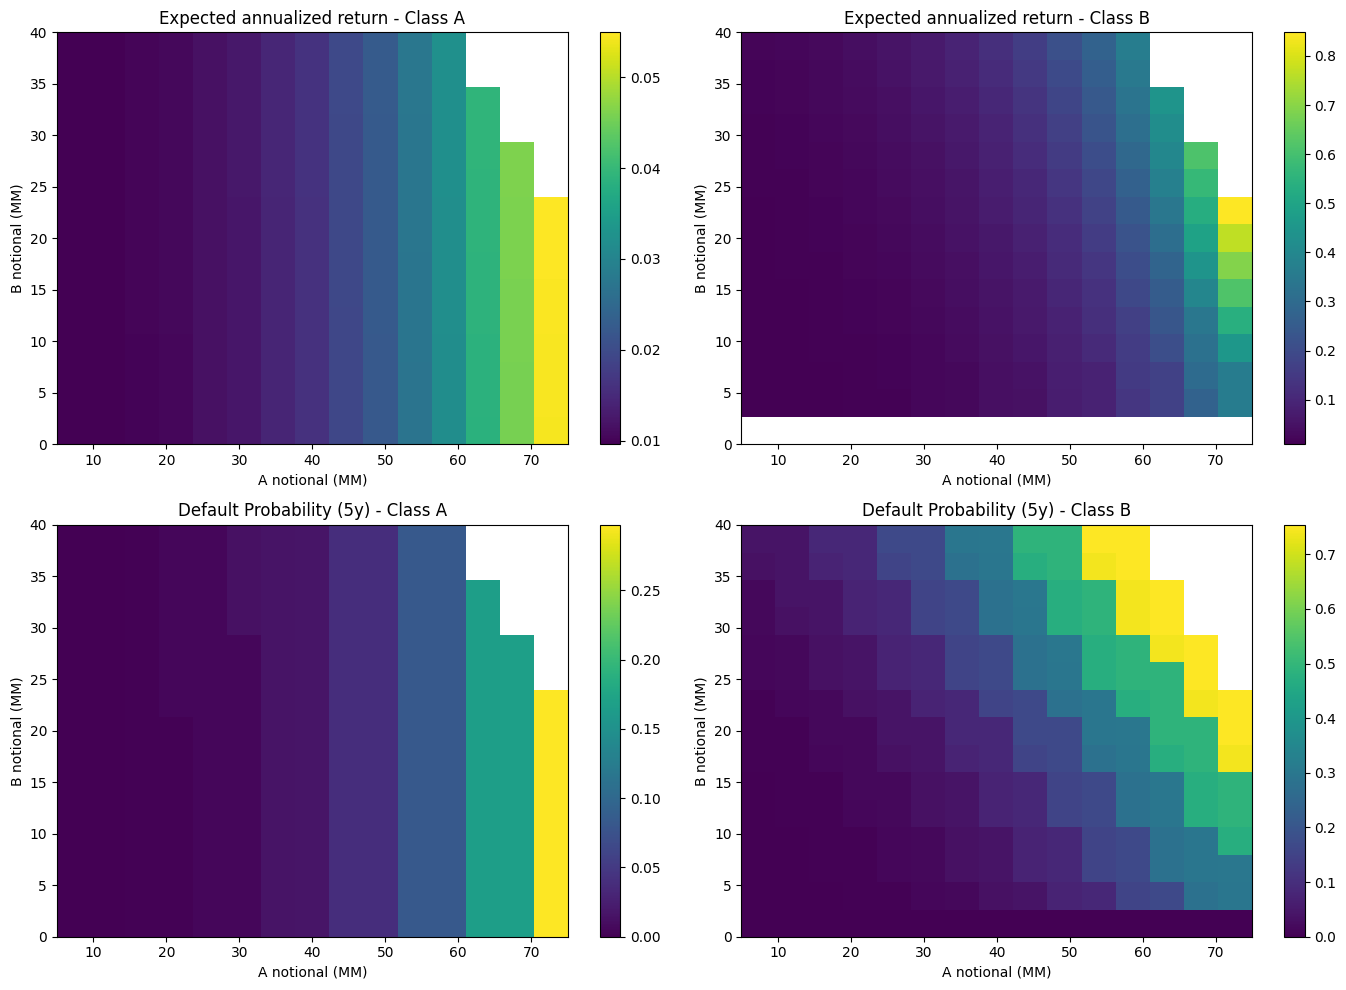

'Selected structure summary'

,A_notional_$M,B_notional_$M,Value_A_$M,Value_B_$M,Value_R_$M,ExpAnnReturn_A_%,ExpAnnReturn_B_%,PD_A_%,PD_B_%
0,34.35,10.00,35.13,9.96,42.57,1.40,3.39,1.61,3.85


In [6]:
# Sensitivity analysis: how A and B sizes affect expected returns and default likelihood

TOTAL_FACE = N_BONDS * FACE  # = 100_000_000

n_A = 15
n_B = 15
A_min = 5_000_000.0
A_max = min(75_000_000.0, TOTAL_FACE)
B_min = 0.0
B_max = min(40_000_000.0, TOTAL_FACE)

A_vals = np.linspace(A_min, A_max, n_A)
B_vals = np.linspace(B_min, B_max, n_B)

# result matrices: rows=B, cols=A
exp_ret_A = np.full((n_B, n_A), np.nan)
exp_ret_B = np.full((n_B, n_A), np.nan)
pd_A      = np.full((n_B, n_A), np.nan)
pd_B      = np.full((n_B, n_A), np.nan)

def total_promised_for_tranche(notional, annual_coupon_rate):
    coupon_q = notional * (annual_coupon_rate / 4.0)
    return coupon_q * N_Q + notional

print("Starting grid computation...")
for iB, B_not in enumerate(B_vals):
    for iA, A_not in enumerate(A_vals):
        # skip infeasible combinations
        if (A_not + B_not) > TOTAL_FACE:
            continue  # keep NaN -> will be masked in plots

        # Waterfall CFs
        A_cf, B_cf = apply_waterfall(agg_cf, A_not, B_not)

        # Expected undiscounted totals
        exp_total_A = A_cf.mean(axis=0).sum()
        exp_total_B = B_cf.mean(axis=0).sum()

        # Market-consistent values via shared-k
        out  = run_risk_charge_pricing(agg_cf, A_not, B_not, ytm_assets=0.09)
        valA = out['Value_A']; valB = out['Value_B']

        # Annualized expected HPR
        if valA > 0:
            hpr_A = (exp_total_A - valA) / valA
            exp_ret_A[iB, iA] = (1 + hpr_A)**(1 / T_YEARS) - 1
        if valB > 0:
            hpr_B = (exp_total_B - valB) / valB
            exp_ret_B[iB, iA] = (1 + hpr_B)**(1 / T_YEARS) - 1

        # Default probability (your original total-sum rule; switch to any-quarter if desired)
        promised_A = total_promised_for_tranche(A_not, 0.02)
        promised_B = total_promised_for_tranche(B_not, 0.04)
        pd_A[iB, iA] = (A_cf.sum(axis=1) < promised_A).mean()
        pd_B[iB, iA] = (B_cf.sum(axis=1) < promised_B).mean()

print("Grid complete | plotting heatmaps...")

# Heatmaps (mask NaNs so infeasible cells are blank) 
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

A_minMM, A_maxMM = A_vals.min() / 1e6, A_vals.max() / 1e6
B_minMM, B_maxMM = B_vals.min() / 1e6, B_vals.max() / 1e6

def show(ax, data, title):
    m = np.ma.array(data, mask=np.isnan(data))
    im = ax.imshow(m, origin='lower', aspect='auto',
                   extent=[A_minMM, A_maxMM, B_minMM, B_maxMM])
    ax.set_title(title)
    ax.set_xlabel('A notional (MM)')
    ax.set_ylabel('B notional (MM)')
    fig.colorbar(im, ax=ax)

show(axes[0,0], exp_ret_A, 'Expected annualized return - Class A')
show(axes[0,1], exp_ret_B, 'Expected annualized return - Class B')
show(axes[1,0], pd_A,      'Default Probability (5y) - Class A')
show(axes[1,1], pd_B,      'Default Probability (5y) - Class B')

plt.tight_layout()
plt.show()


# Print a small summary for the 'current' structure (A_star if present else initial) 
A_test = float(A_for_mezz) if 'A_for_mezz' in globals() else float(A_NOTIONAL_INITIAL)
B_test = float(B_for_mezz) if 'B_for_mezz' in globals() else float(B_NOTIONAL_INITIAL)

out = run_risk_charge_pricing(agg_cf, A_test, B_test, ytm_assets=0.09)
A_cf_t, B_cf_t = apply_waterfall(agg_cf, A_test, B_test)
exp_total_A = A_cf_t.mean(axis=0).sum(); exp_total_B = B_cf_t.mean(axis=0).sum()
valA = out['Value_A']; valB = out['Value_B']
annA = (1 + (exp_total_A - valA) / valA)**(1/T_YEARS) - 1 if valA>0 else np.nan
annB = (1 + (exp_total_B - valB) / valB)**(1/T_YEARS) - 1 if valB>0 else np.nan
promised_A = total_promised_for_tranche(A_test, 0.02)
promised_B = total_promised_for_tranche(B_test, 0.04)
pdA = np.mean(A_cf_t.sum(axis=1) < promised_A)
pdB = np.mean(B_cf_t.sum(axis=1) < promised_B)

summary = pd.DataFrame([{
    "A_notional_$M": A_test/1e6, "B_notional_$M": B_test/1e6,
    "Value_A_$M": valA/1e6, "Value_B_$M": valB/1e6, "Value_R_$M": out['Value_R']/1e6,
    "ExpAnnReturn_A_%": annA*100, "ExpAnnReturn_B_%": annB*100,
    "PD_A_%": pdA*100, "PD_B_%": pdB*100
}])
display("Selected structure summary", summary)